# In case you run in colab

In [1]:
from google.colab import files
uploaded = files.upload()

Saving 0000_label.png to 0000_label (1).png


# Function definitions

In [2]:
import numpy as np
import cv2

# orientation of barcode
def get_barcode_angle(image):
  gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
  gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

  gx = np.maximum(0, gx)
  gy = np.maximum(0, gy)

  gradient_map = gx + gy

  F = np.fft.fft2(gradient_map - gradient_map.mean())
  Fshift = np.fft.fftshift(F)
  mag = np.abs(Fshift)

  h, w = gradient_map.shape
  cy, cx = h // 2, w // 2

  dc_radius = 5   # pixels around the center
  Yf, Xf = np.ogrid[:h, :w]
  dy, dx = Yf - cy, Xf - cx
  R = np.sqrt(dx**2 + dy**2)

  mag_no_dc = mag.copy()
  mag_no_dc[R <= dc_radius] = 0

  # -----------------------
  # 4. Radial high-pass: ignore very low freqs (big edges, background)
  # -----------------------
  # r_min as a fraction of the min dimension
  r_min_frac = 0.2
  r_min = int(min(h, w) * r_min_frac)
  mag_band = mag_no_dc.copy()
  mag_band[R < r_min] = 0

  # -----------------------
  # 5. Find dominant off-center peak *inside this band*
  # -----------------------
  flat_idx_sorted = np.argsort(mag_band.ravel())[::-1]
  py1, px1 = np.unravel_index(flat_idx_sorted[0], mag_band.shape)

  # Symmetric counterpart (for real-valued images)
  py2, px2 = 2 * cy - py1, 2 * cx - px1

  # Direction of frequency (normal to stripes)
  dy1, dx1 = (py1 - py2), (px1 - px2)
  angle_freq = np.degrees(np.arctan2(dx1, dy1))
  angle_stripes = (angle_freq + 90) % 180

  return angle_stripes


# find periodicity
def get_rotated_barcode_coordinate(rotated_original_image_stretched_edged):
  F = np.fft.fft2(rotated_original_image_stretched_edged - rotated_original_image_stretched_edged.mean())
  Fshift = np.fft.fftshift(F)

  mag = np.abs(Fshift)
  h, w = rotated_original_image_stretched_edged.shape

  cy, cx = h // 2, w // 2

  # -----------------------
  # 3. Remove DC blob
  # -----------------------
  dc_radius = 5   # pixels around the center
  Yf, Xf = np.ogrid[:h, :w]
  dy, dx = Yf - cy, Xf - cx
  R = np.sqrt(dx**2 + dy**2)

  mag_no_dc = mag.copy()
  mag_no_dc[R <= dc_radius] = 0

  # -----------------------
  # 4. Radial high-pass: ignore very low freqs (big edges, background)
  # -----------------------
  # r_min as a fraction of the min dimension
  r_min_frac = 0.15
  r_min = int(min(h, w) * r_min_frac)
  mag_band = mag_no_dc.copy()
  mag_band[R < r_min] = 0

  # -----------------------
  # 5. Find dominant off-center peak *inside this band*
  # -----------------------
  flat_idx_sorted = np.argsort(mag_band.ravel())[::-1]
  py1, px1 = np.unravel_index(flat_idx_sorted[0], mag_band.shape)

  # Symmetric counterpart (for real-valued images)
  py2, px2 = 2 * cy - py1, 2 * cx - px1

  # Frequency radius of the peak (for period estimate)
  freq_radius = R[py1, px1]   # in "frequency pixels"

  # Direction of frequency (normal to stripes)
  dy1, dx1 = (py1 - py2), (px1 - px2)
  angle_freq = np.degrees(np.arctan2(dx1, dy1))

  # Stripe direction is perpendicular
  angle_stripes = (angle_freq + 90) % 180

  # -----------------------
  # 6. Build band-pass mask around the two peaks
  # -----------------------
  mask = np.zeros_like(mag, dtype=np.float32)
  peak_box_radius = 10

  for (py, px) in [(py1, px1), (py2, px2)]:
      y0 = max(py - peak_box_radius, 0)
      y1 = min(py + peak_box_radius + 1, h)
      x0 = max(px - peak_box_radius, 0)
      x1 = min(px + peak_box_radius + 1, w)
      mask[y0:y1, x0:x1] = 1.0

  # -----------------------
  # 7. Apply mask in frequency domain and inverse FFT
  # -----------------------
  F_filt = Fshift * mask
  img_filt = np.fft.ifft2(np.fft.ifftshift(F_filt))
  resp = np.abs(img_filt)
  resp /= resp.max() + 1e-8

  # -----------------------
  # 8. Threshold to get barcode mask
  # -----------------------
  resp_thresh = 0.3  # tune this
  barcode_mask = (resp > resp_thresh).astype(np.float32)

  coords = cv2.findNonZero(barcode_mask)
  x, y, w, h = cv2.boundingRect(coords)
  return (x, y, w, h)


def find_barcode(original_image):
  angle = get_barcode_angle(original_image)
  h, w = original_image.shape
  center = (w // 2, h // 2)
  # Get rotation matrix
  M = cv2.getRotationMatrix2D(center, 180-angle, scale=1.5)

  # Rotate
  rotated_original_image = cv2.warpAffine(original_image, M, (w, h))

  # introduce contrast
  alpha = 3
  rotated_original_image_stretched = cv2.convertScaleAbs(rotated_original_image, alpha=alpha, beta=0)

  # get derivative on the x axis
  rotated_original_image_stretched_edged = cv2.Sobel(rotated_original_image_stretched, cv2.CV_32F, 1, 0, ksize=3)
  rotated_original_image_stretched_edged = np.maximum(0, rotated_original_image_stretched_edged)

  (x, y, w, h) = get_rotated_barcode_coordinate(rotated_original_image_stretched_edged)

  offset = 10
  barcode = rotated_original_image[max(y-offset, 0):min(y+h+offset, rotated_original_image.shape[0]),
                                  max(x-offset, 0):min(x+w+offset, rotated_original_image.shape[1])]

  return barcode, rotated_original_image


# Run the barcode extraction. Change line 5 to the directory of images

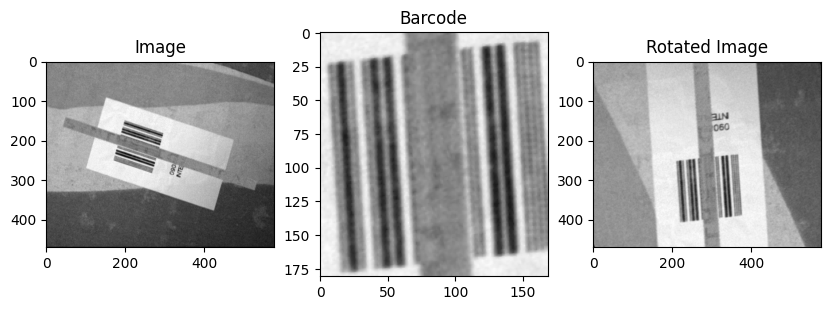

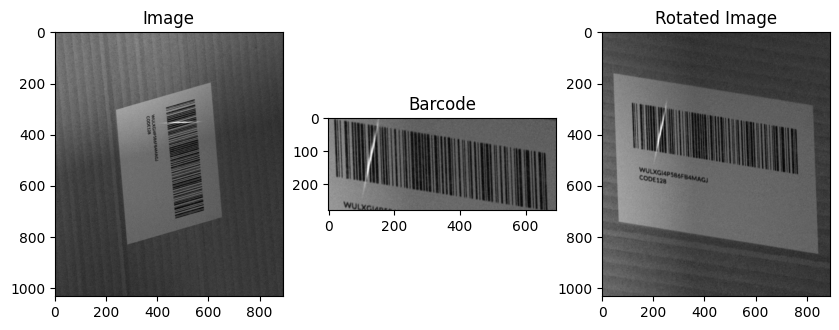

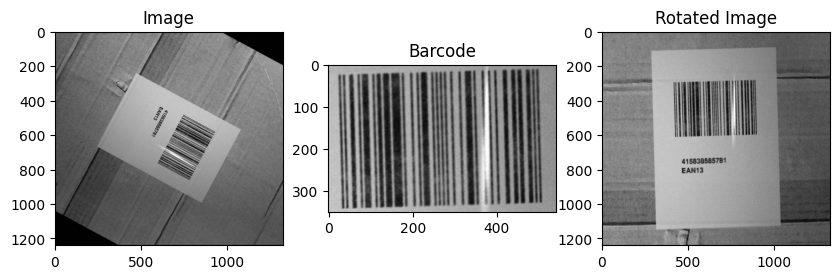

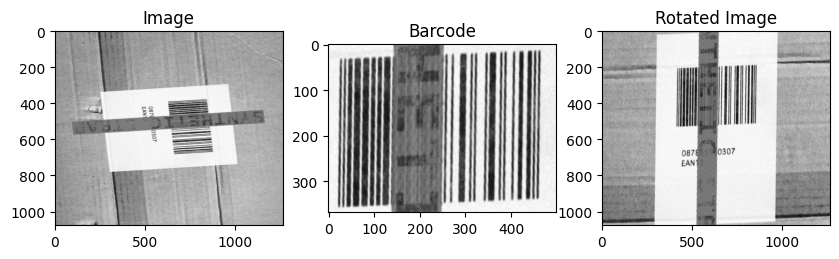

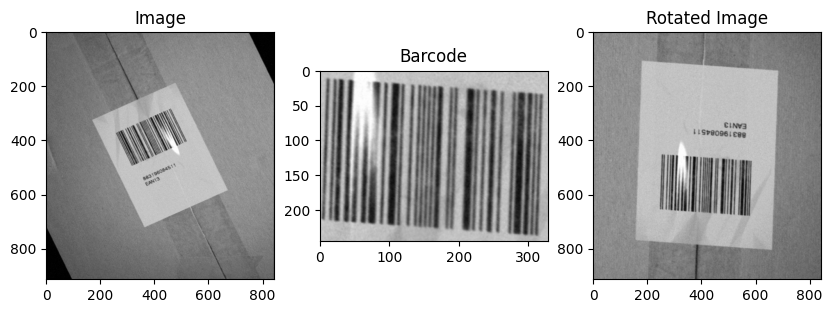

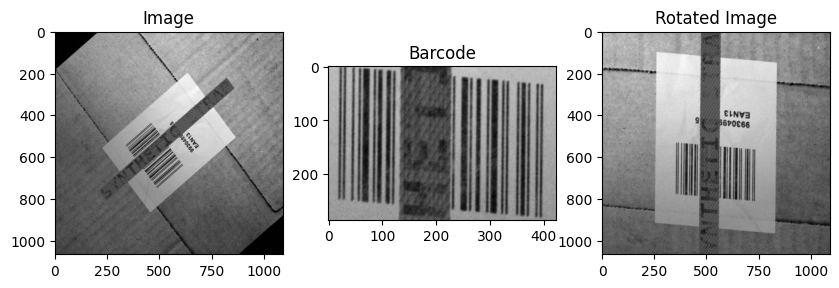

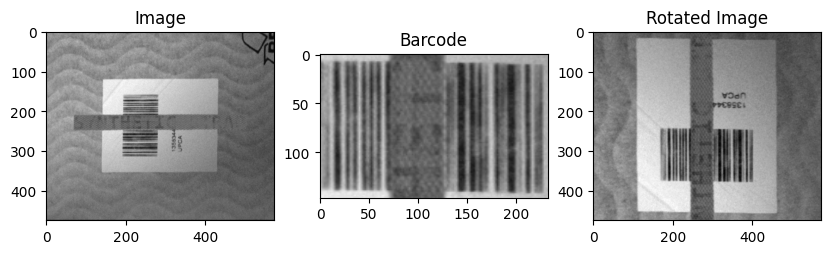

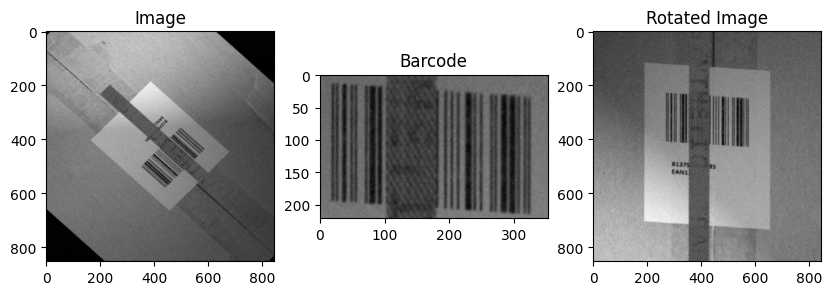

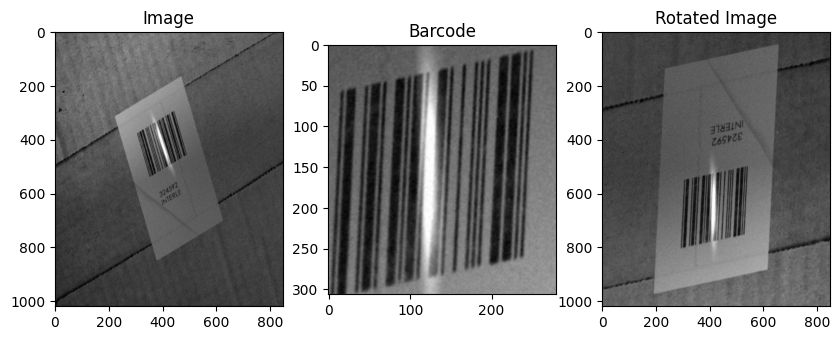

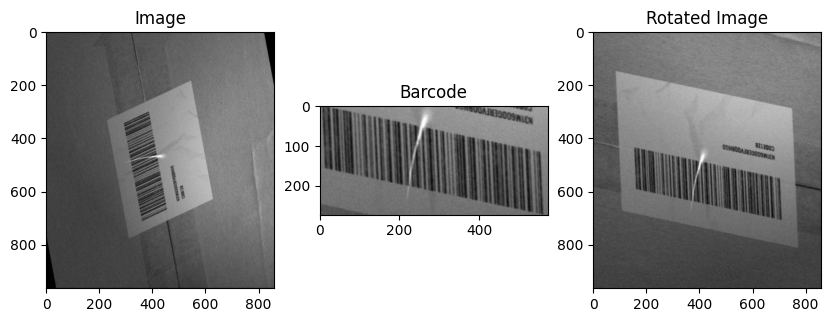

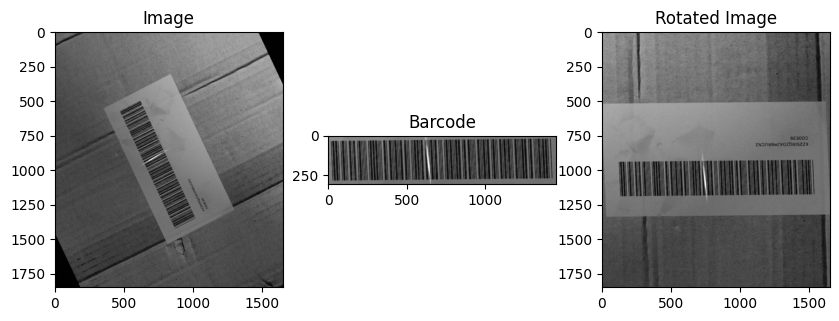

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image


## load the images
image_folder = '.' ## change the address here
images = os.listdir(image_folder)
images = [image for image in images if image.endswith('png')]

# Load the image
for image_path in images[::-1]:
  image_path = f'/content/{image_path}'
  image = cv2.imread(image_path, 0) # Load as grayscale for Radon transform
  barcode, rotated_original_image = find_barcode(image)

  barcode = Image.fromarray(barcode).convert('RGB')

  ## Vizualize
  plt.figure(figsize=(10, 8))

  plt.subplot(1, 3, 1)
  plt.imshow(image, cmap="gray")
  plt.title("Image")

  plt.subplot(1, 3, 2)
  plt.imshow(barcode, cmap="gray")
  plt.title("Barcode")

  plt.subplot(1, 3, 3)
  plt.imshow(rotated_original_image, cmap="gray")
  plt.title("Rotated Image")
  plt.show()